Coil force calculations for Next Step Fusion design
==========

**Note:** Running this example requires the [triangle](https://pypi.org/project/triangle/) python package, which is installable using `pip` or other standard methods.

In [2]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [3]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('../nextstep_mesh_0801.h5')

## Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed

In [5]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 =1*3) ## F0 = B0 * R0

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          aba6d8f
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  6.143E+00
    # of points  =   10020
    # of edges   =   29927
    # of cells   =   19908
    # of boundary points =     130
    # of boundary edges  =     130
    # of boundary cells  =     130
  Resolution statistics:
    hmin =  3.000E-03
    hrms =  2.845E-02
    hmax =  1.1

# Compute forces on coils for a vacuum state

## Set coil currents and compute vacuum equilibrium

   1  4.2578E+04


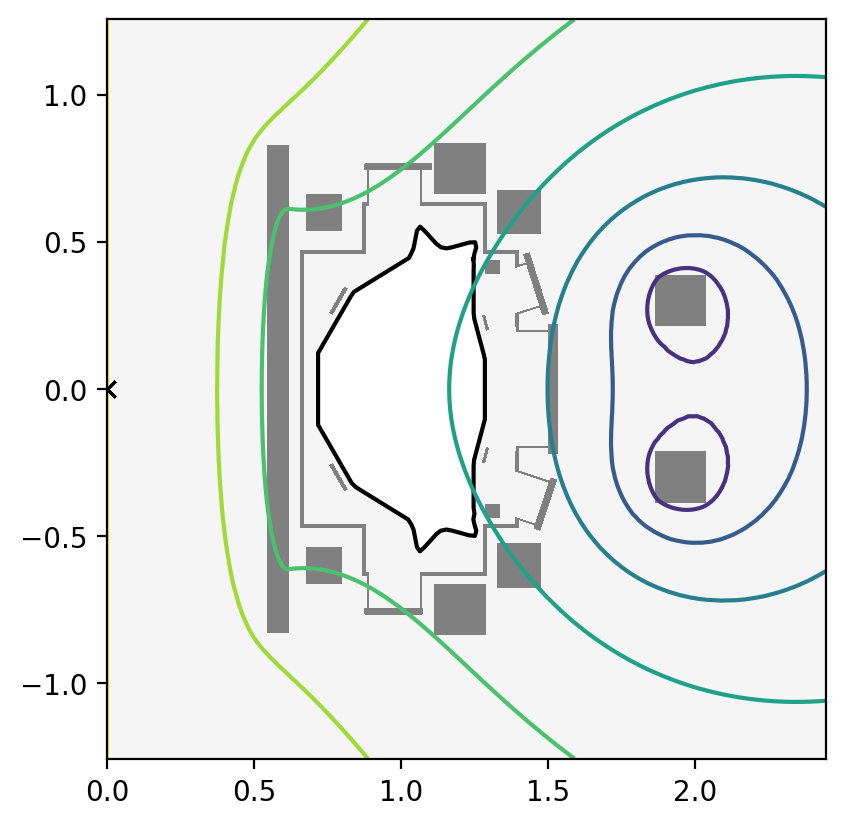

In [6]:
coil_currents = np.zeros((mygs.ncoils,), dtype=np.float64)
coil_currents[mygs.coil_sets['CS_1']['id']] = -1.5E6
coil_currents[mygs.coil_sets['CS_2']['id']] = -3.0E6
coil_currents[mygs.coil_sets['CS_3']['id']] = -1.5E6

coil_currents[mygs.coil_sets['PF_4U']['id']] = -1.E6
coil_currents[mygs.coil_sets['PF_4L']['id']] = -1.E6

mygs.set_coil_currents(coil_currents)
mygs.set_psi(0.0*mygs.get_psi())
psi, __ = mygs.vac_solve()
mygs.set_psi(psi)
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax, normalized = False)

## Load toroidal coil mesh for for calculations

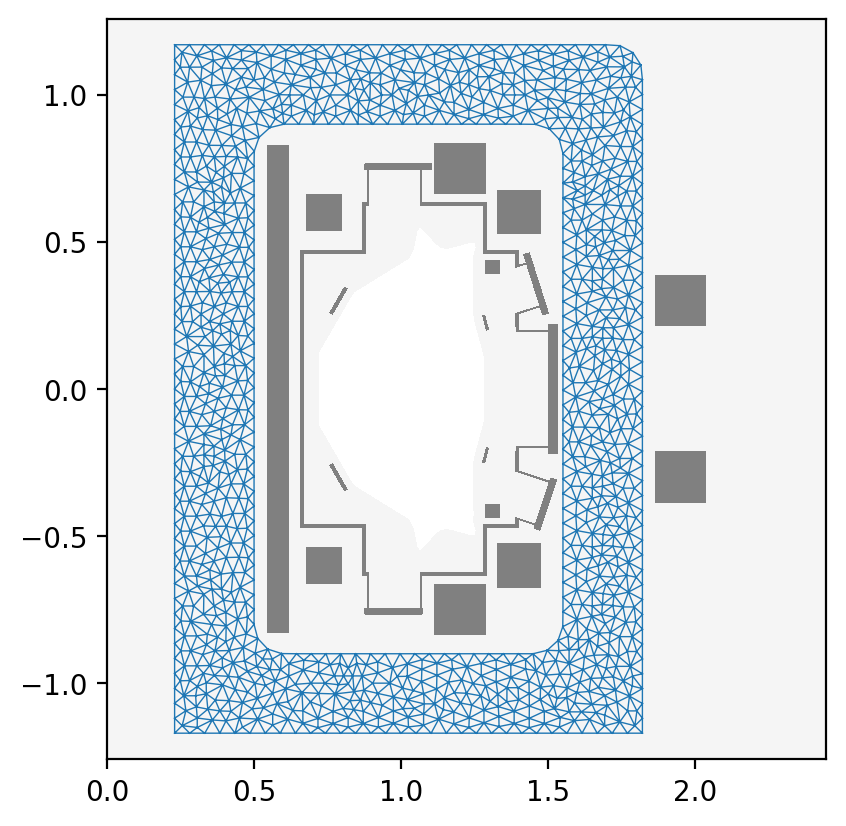

In [7]:
with open('TF_mesh.json', 'r') as fid:
    input_dict = json.load(fid)
tf_pts = np.array(input_dict['pts'])
tf_lc = np.array(input_dict['lc'])

# Plot mesh
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
_ = ax.triplot(tf_pts[:,0],tf_pts[:,1],tf_lc,lw=0.5)

## Sample B-field on TF grid points

Field is stored as \[B_r, B_phi, B_z\]

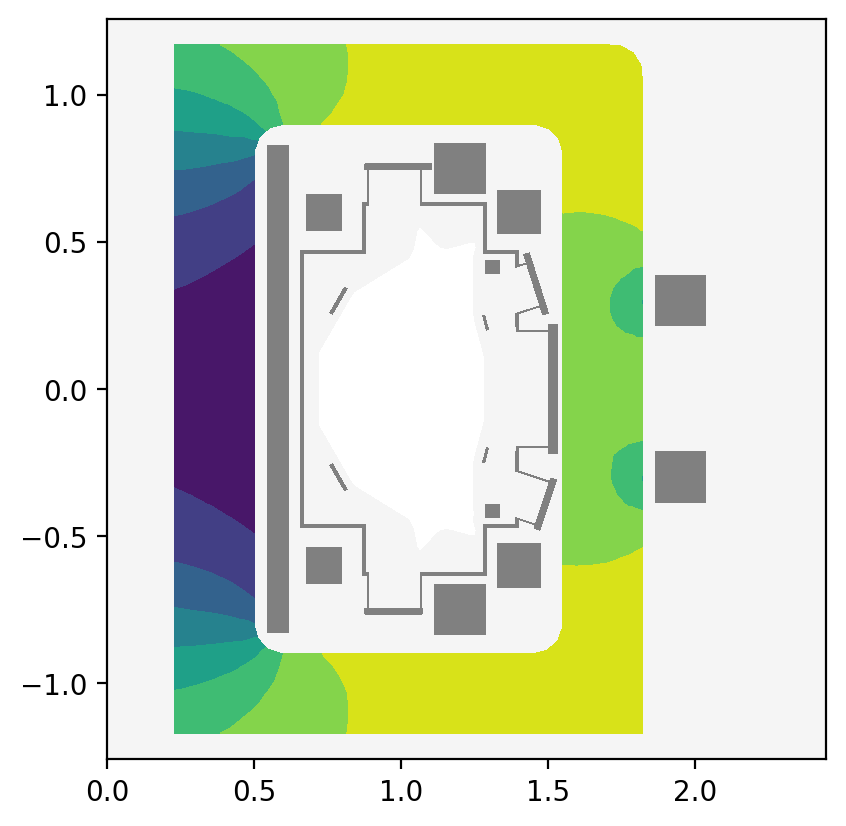

In [8]:
field_eval = mygs.get_field_eval('B')
B_TF = np.zeros((tf_pts.shape[0],3))
for i in range(tf_pts.shape[0]):
    B_TF[i,:] = field_eval.eval(tf_pts[i,:])

# Plot vertical field
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
_ = ax.tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,B_TF[:,2])

## Setup approximate TF current density on same grid

In [9]:
inner_R0 = 0.260
leg_width = 0.270
bore = 1.050
height = 2.340
inner_radius = 0.100
leg_thickness = 0.190
TF_current = 313.0*3.E3
#
J_TF = np.zeros((tf_pts.shape[0],2))
for i in range(tf_pts.shape[0]):
    if (abs(tf_pts[i,1]) > (height/2.0 - leg_width - inner_radius)) and abs(tf_pts[i,0]-(inner_R0+leg_width+bore/2.0)) > (bore/2.0-inner_radius):
        if tf_pts[i,0] > 1.0:
            R0 = inner_R0+leg_width+bore-inner_radius
        else:
            R0 = inner_R0+leg_width+inner_radius
        Z0 = np.sign(tf_pts[i,1])*(height/2.0-leg_width-inner_radius)
        theta = np.arctan2(tf_pts[i,1]-Z0,tf_pts[i,0]-R0)
        J_TF[i,:] = [-np.sin(theta),np.cos(theta)]
    elif abs(tf_pts[i,1]) >= height/2.0 - leg_width:
        J_TF[i,:] = [-np.sign(tf_pts[i,1]),0.0]
    else:
        J_TF[i,:] = [0.0,np.sign(tf_pts[i,0]-(inner_R0+leg_width+bore/2.0))]
J_TF *= TF_current/leg_width/leg_thickness

## Plot Force inputs

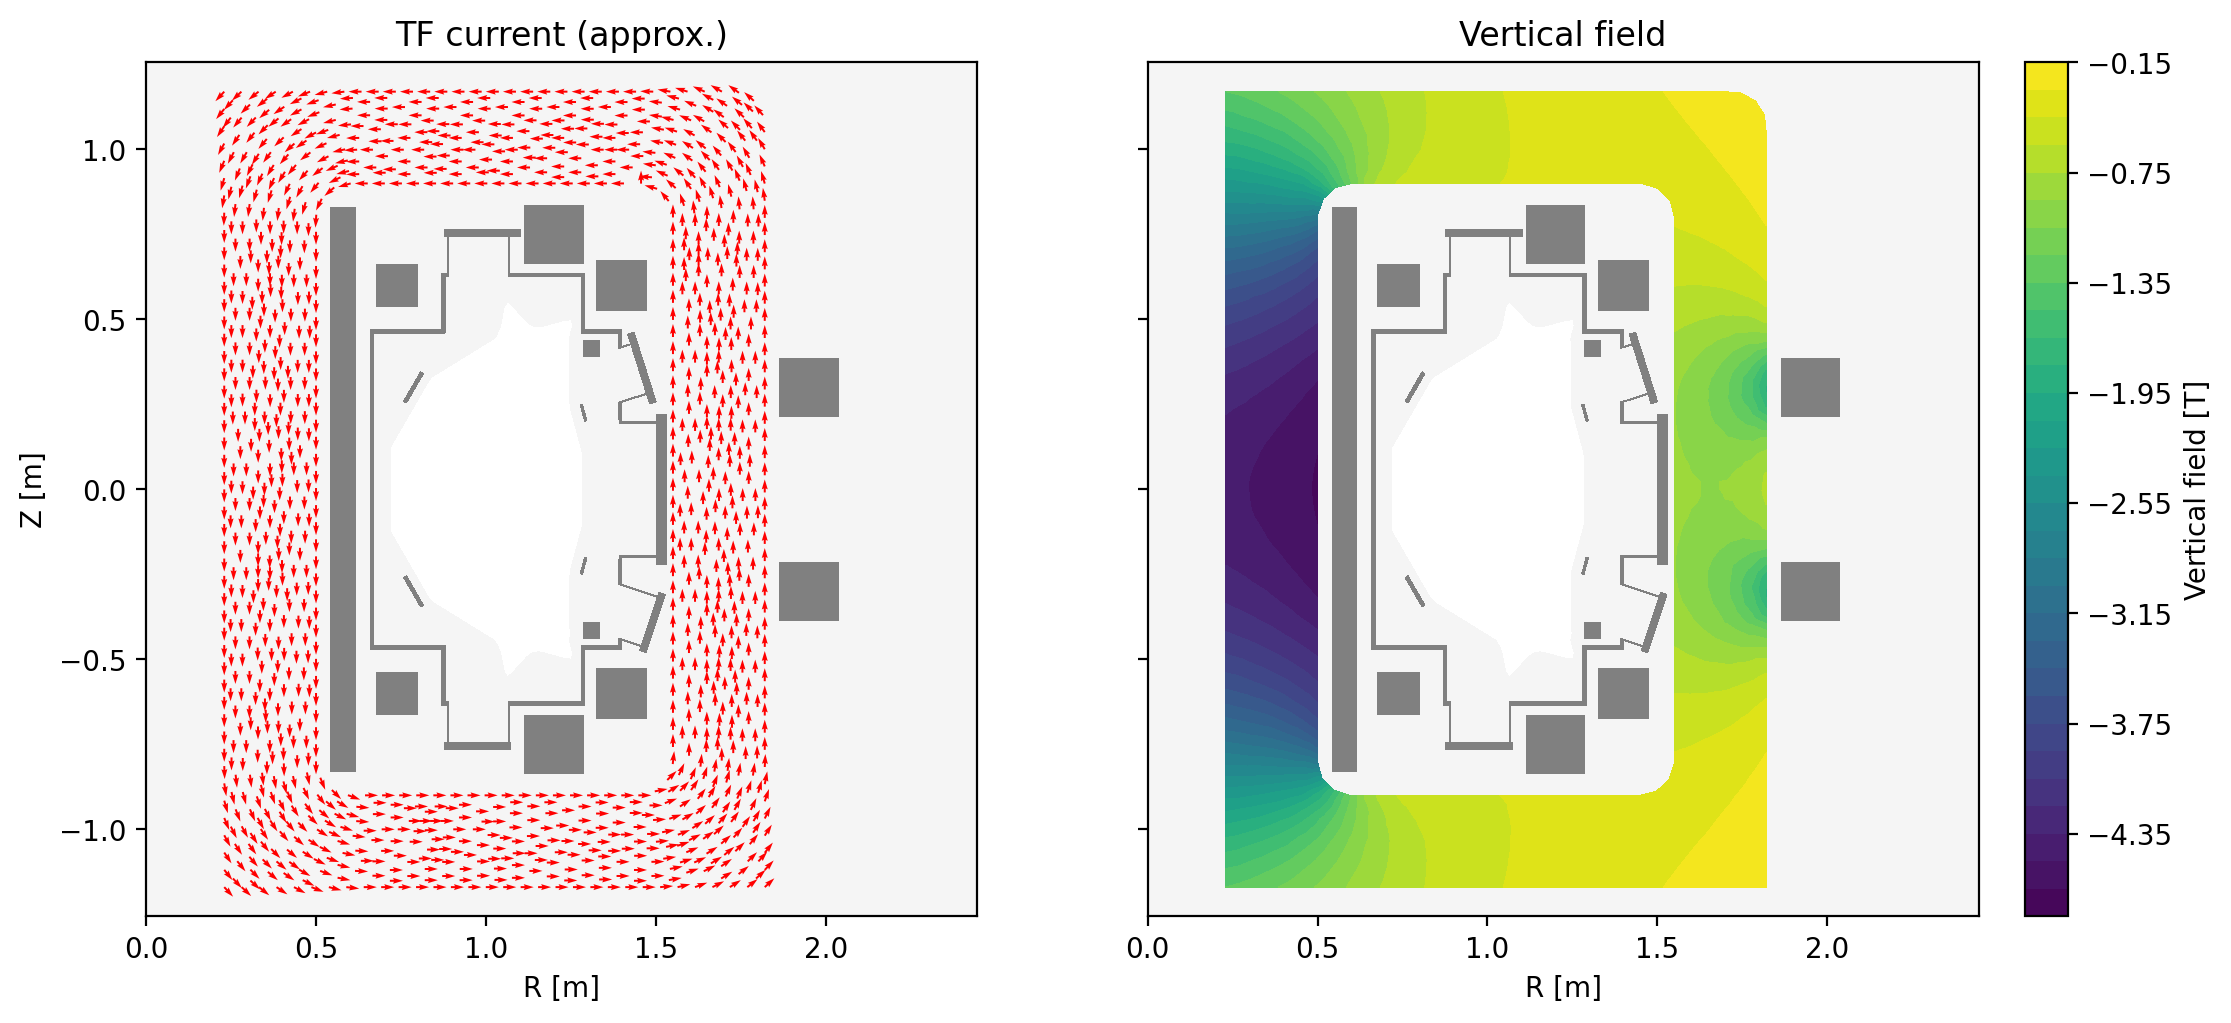

In [10]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(11,5),constrained_layout=True)
mygs.plot_machine(fig,ax[1],limiter_color=None)
clf = ax[1].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,B_TF[:,2],40)
fig.colorbar(clf,ax=ax[1],label='Vertical field [T]')
ax[1].set_title('Vertical field')
mygs.plot_machine(fig,ax[0],limiter_color=None)
clf = ax[0].quiver(tf_pts[:,0],tf_pts[:,1],J_TF[:,0],J_TF[:,1],color='r')
ax[0].set_title('TF current (approx.)')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
_ = ax[1].set_xlabel('R [m]')
# fig.savefig('NSF-TF_ex.png',dpi=200)

## Plot toroidal pressure (overturning)
Pressure is J_r * B_z * leg_thickness

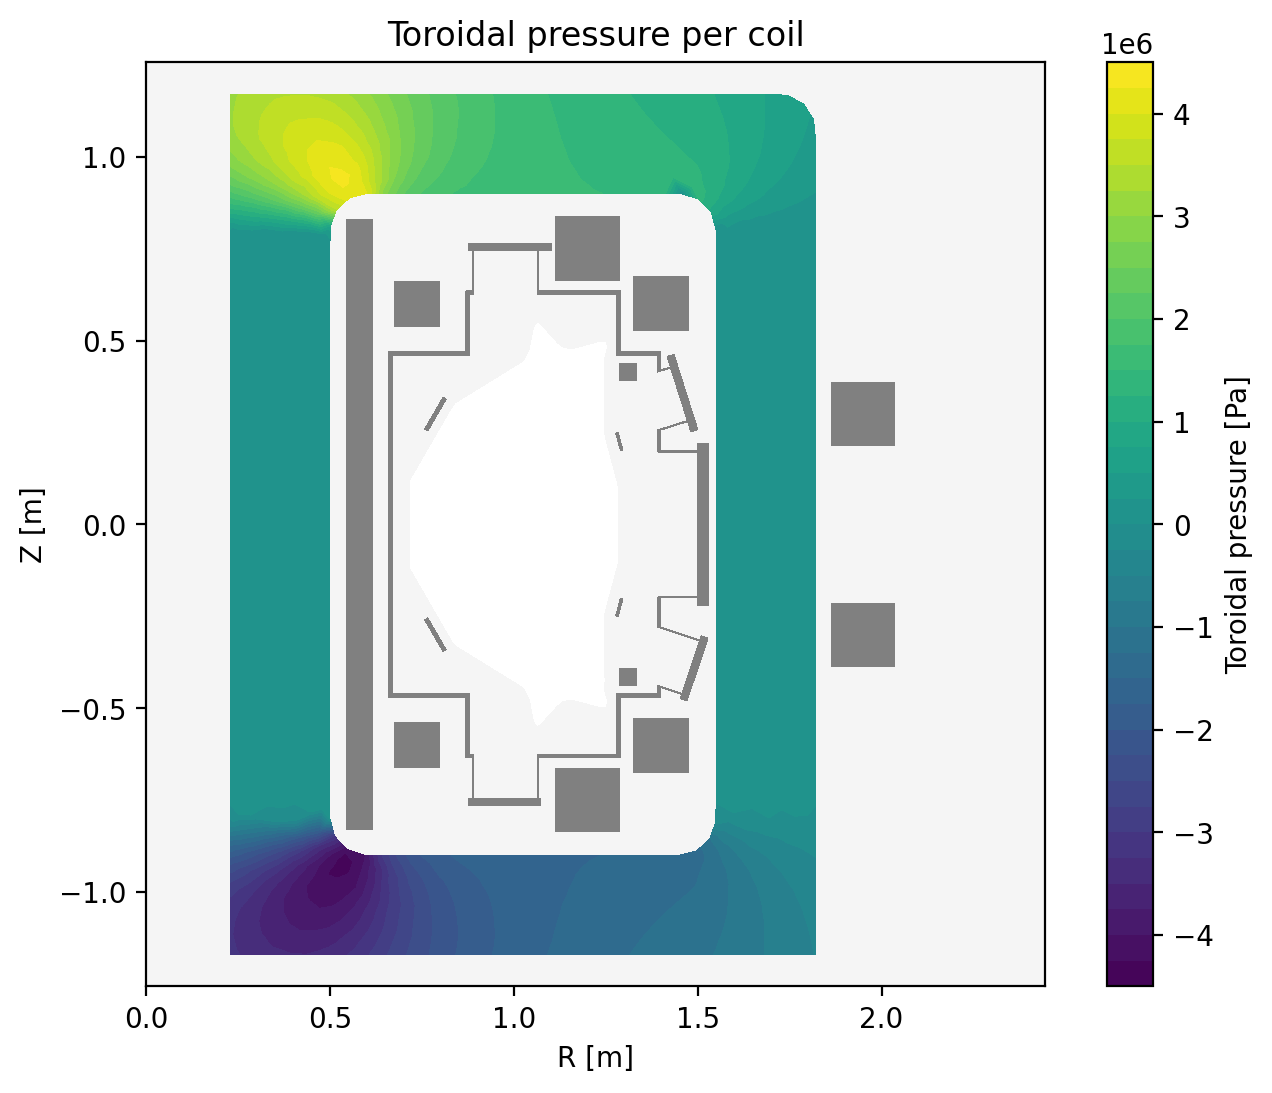

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
mygs.plot_machine(fig,ax,limiter_color=None)
clf = ax.tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,J_TF[:,0]*B_TF[:,2]*leg_thickness,40)
fig.colorbar(clf,ax=ax,label='Toroidal pressure [Pa]')
ax.set_ylabel('Z [m]')
ax.set_xlabel('R [m]')
_ = ax.set_title('Toroidal pressure per coil')
# fig.savefig('NSF-TF_forces_ex.png',dpi=200)

## Save raw force information

In [12]:
with open('TF_force.json', 'w+') as fid:
    fid.write(json.dumps({
        "pts": tf_pts.tolist(),
        "lc": tf_lc.tolist(),
        "P_tor": (J_TF[:,0]*B_TF[:,2]*leg_thickness).tolist()
    }))

## Compute total overturning force and moment (per coil)
As the force cancels if intergrated over the whole coil for an up-down symmetric field, the force on one half of the coil is reported.

In [13]:
overturning_force = 0.0
overturning_moment = 0.0
for i in range(tf_lc.shape[0]):
    v1 = tf_pts[tf_lc[i,1],:]-tf_pts[tf_lc[i,0],:]
    v2 = tf_pts[tf_lc[i,2],:]-tf_pts[tf_lc[i,0],:]
    area = np.linalg.norm(np.cross(v1,v2))/2.0
    rcc = (tf_pts[tf_lc[i,2],:]+tf_pts[tf_lc[i,1],:]+tf_pts[tf_lc[i,0],:])/3.0
    Jcc = (J_TF[tf_lc[i,2],0]+J_TF[tf_lc[i,1],0]+J_TF[tf_lc[i,0],0])/3.0
    Bcc = (B_TF[tf_lc[i,2],2]+B_TF[tf_lc[i,1],2]+B_TF[tf_lc[i,0],2])/3.0
    overturning_force += np.sign(rcc[1])*area*Jcc*Bcc*leg_thickness
    overturning_moment += rcc[1]*area*Jcc*Bcc*leg_thickness
print('Overturning force per half coil = {0:10.2F} [kN]'.format(overturning_force/2.0/1.E3))
print('Overturning moment per coil     = {0:10.2F} [kN-m]'.format(overturning_moment/1.E3))

Overturning force per half coil =     923.43 [kN]
Overturning moment per coil     =    1888.19 [kN-m]


## Compute force on PF coils

CS_1     1.0339E+07    -5.6830E+06
CS_2     2.4956E+07     3.9550E+01
CS_3     1.0340E+07     5.6839E+06
PF_1U     0.0000E+00    -0.0000E+00
PF_1L     0.0000E+00    -0.0000E+00
PF_2U     0.0000E+00    -0.0000E+00
PF_2L     0.0000E+00    -0.0000E+00
PF_3U     0.0000E+00    -0.0000E+00
PF_3L     0.0000E+00    -0.0000E+00
PF_4U     3.2780E+06    -4.0796E+06
PF_4L     3.2790E+06     4.0774E+06
DIV_U     0.0000E+00    -0.0000E+00
DIV_L     0.0000E+00    -0.0000E+00


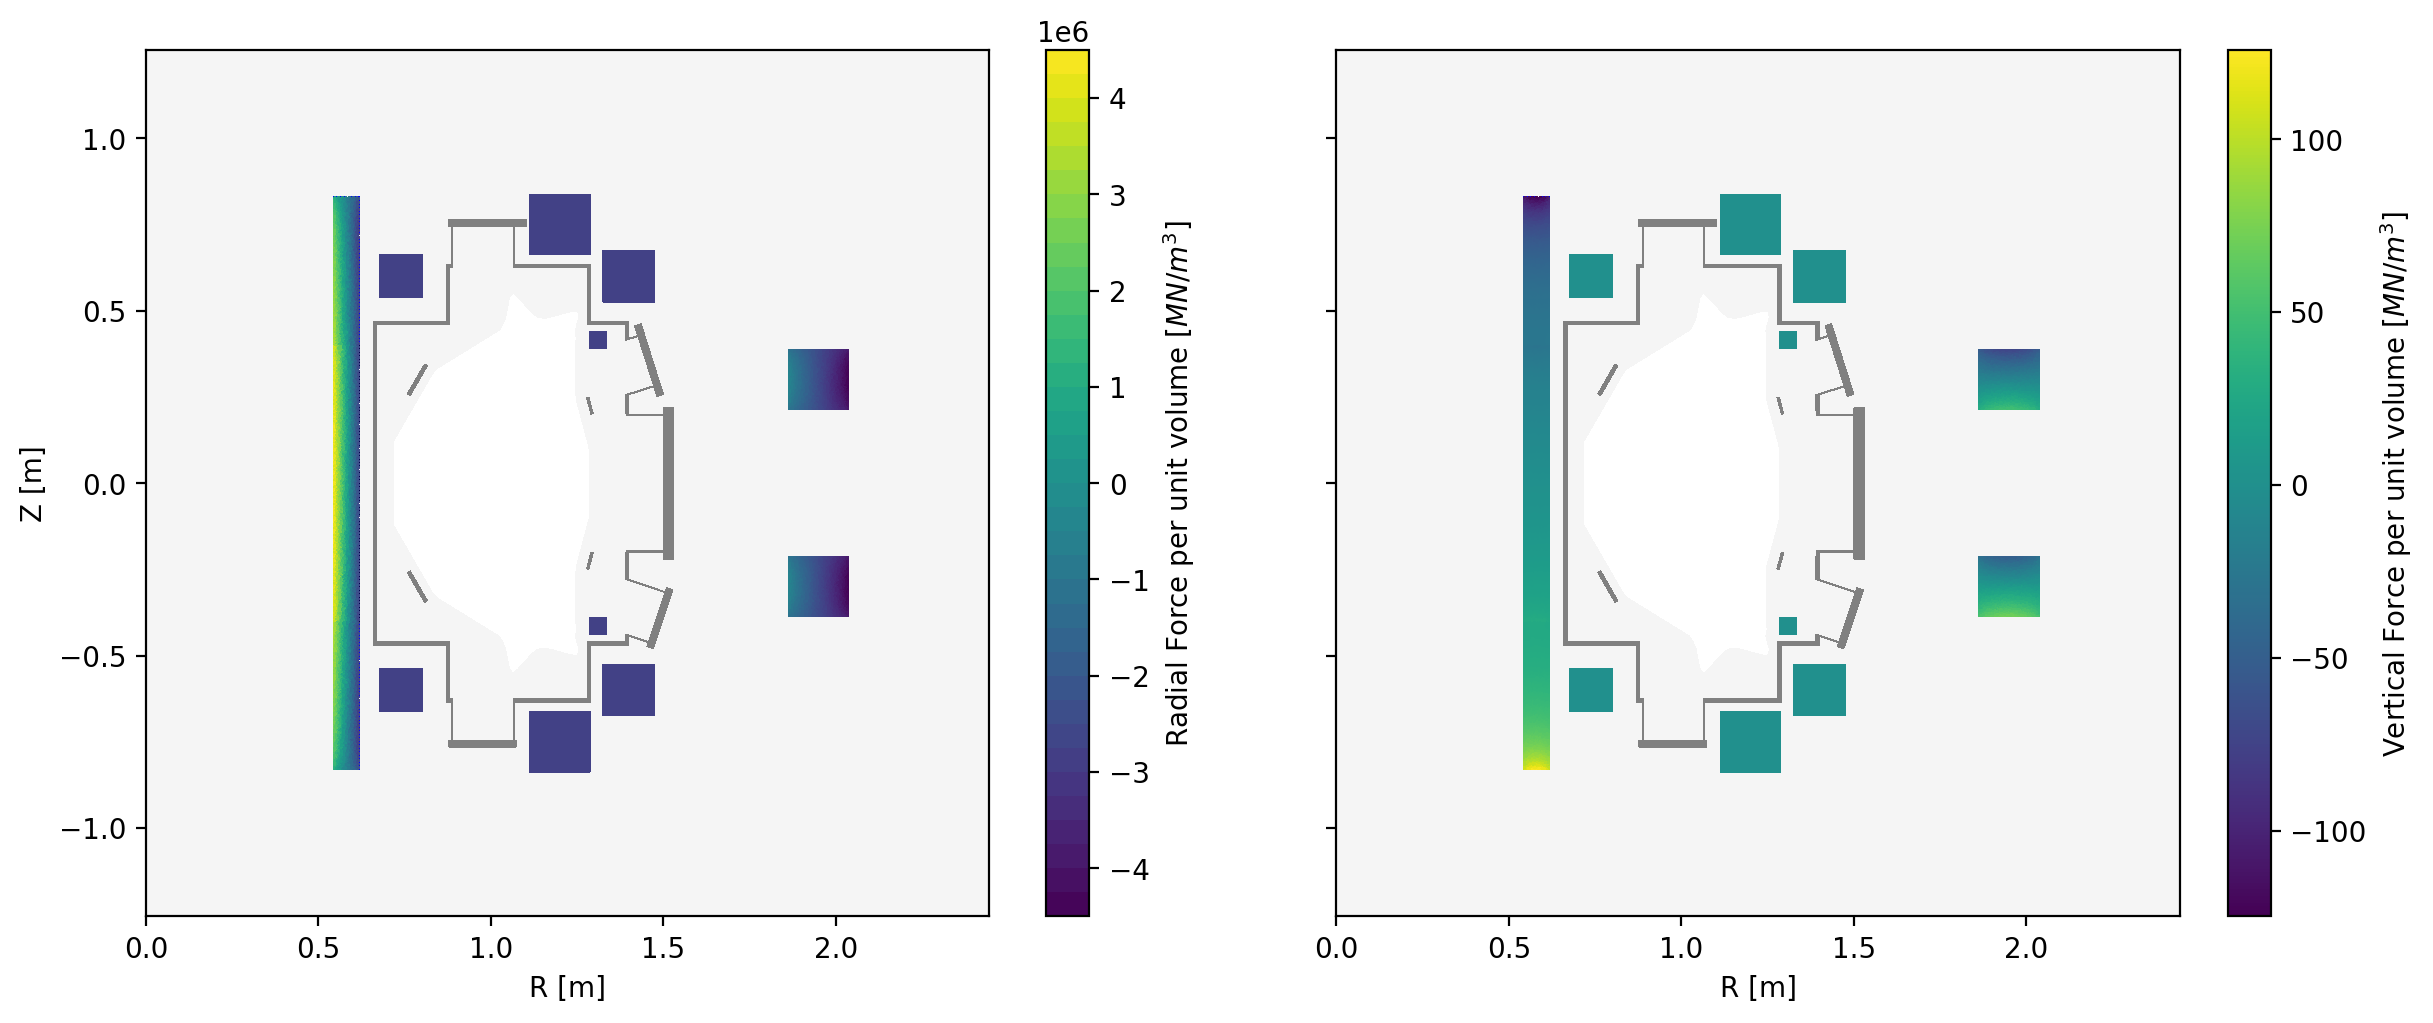

In [14]:
coil_currents, reg_currents = mygs.get_coil_currents()
B_PF = np.zeros((mesh_pts.shape[0],3))
F_PF = np.zeros((mesh_lc.shape[0],2))
F_PF[:] = np.NaN
pt_mask = np.zeros((mesh_pts.shape[0],), dtype=np.int32)
for key, coil in coil_dict.items():
    pt_mask[mesh_lc[mesh_reg==coil['reg_id'],:]] = 1
for i in range(mesh_pts.shape[0]):
    if pt_mask[i] == 0:
        continue
    B_PF[i,:] = field_eval.eval(mesh_pts[i,:])
for key, coil in mygs.coil_sets.items():
    coil_area = 0.0
    coil_force = np.array([0.0,0.0])
    for subcoil in coil['sub_coils']:
        subcoil_area = 0.0
        nc = np.sum(mesh_reg==subcoil['reg_id'])
        Bcc = np.zeros((nc,3))
        for i, lc in enumerate(mesh_lc[mesh_reg==subcoil['reg_id'],:]):
            v1 = mesh_pts[lc[1],:]-mesh_pts[lc[0],:]
            v2 = mesh_pts[lc[2],:]-mesh_pts[lc[0],:]
            area = np.linalg.norm(np.cross(v1,v2))/2.0
            rcc = (mesh_pts[lc[2],:]+mesh_pts[lc[1],:]+mesh_pts[lc[0],:])/3.0
            Bcc[i,:] = (B_PF[lc[2],:]+B_PF[lc[1],:]+B_PF[lc[0],:])/3.0
            coil_force += Bcc[i,[2,0]]*reg_currents[subcoil['reg_id']-1]*area*2.0*np.pi*rcc[0]
            subcoil_area += area
        coil_area += subcoil_area
        Jtor_subcoil = coil_currents[coil['id']]*subcoil['nturns']/subcoil_area
        F_PF[mesh_reg==subcoil['reg_id'],0] = Bcc[:,2]*Jtor_subcoil
        F_PF[mesh_reg==subcoil['reg_id'],1] = -Bcc[:,0]*Jtor_subcoil
    coil_force /= coil_area
    print('{0:4} {1:14.4E} {2:14.4E}'.format(key,coil_force[0],-coil_force[1]))

# Plot results
fig, ax = plt.subplots(1,2,figsize=(12,5),sharey=True,constrained_layout=True)
# Radial force
mygs.plot_machine(fig,ax[0],limiter_color=None,coil_colormap='seismic',coil_symmap=True,coil_clabel=None)
ax[0].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,0]/1.E6)
fig.colorbar(clf,ax=ax[0],label=r'Radial Force per unit volume [$MN/m^3$]')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
# Vertical force
mygs.plot_machine(fig,ax[1],limiter_color=None,coil_colormap='seismic',coil_symmap=True,coil_clabel=None)
clf = ax[1].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,1]/1.E6)
fig.colorbar(clf,ax=ax[1],label=r'Vertical Force per unit volume [$MN/m^3$]')
_ = ax[1].set_xlabel('R [m]')

# Compute forces on coils for an example equilibrium

## Solve for example NT equilibrium

Starting non-linear GS solver
     1  6.0398E+00  2.8468E+00  9.8198E-03  1.0395E+00 -4.9418E-05 -0.0000E+00
     2  5.9488E+00  2.8288E+00  1.8320E-03  1.0387E+00 -5.5009E-05 -0.0000E+00
     3  5.8787E+00  2.8056E+00  3.6733E-04  1.0381E+00 -5.6896E-05 -0.0000E+00
     4  5.8447E+00  2.7936E+00  1.3899E-04  1.0378E+00 -5.7897E-05 -0.0000E+00
     5  5.8291E+00  2.7879E+00  6.9191E-05  1.0376E+00 -5.8358E-05 -0.0000E+00
     6  5.8222E+00  2.7853E+00  3.2879E-05  1.0375E+00 -5.8588E-05 -0.0000E+00
     7  5.8193E+00  2.7842E+00  1.4865E-05  1.0375E+00 -5.8687E-05 -0.0000E+00
     8  5.8181E+00  2.7837E+00  6.5078E-06  1.0374E+00 -5.8721E-05 -0.0000E+00
     9  5.8176E+00  2.7835E+00  2.7882E-06  1.0374E+00 -5.8725E-05 -0.0000E+00
    10  5.8174E+00  2.7834E+00  1.1762E-06  1.0374E+00 -5.8718E-05 -0.0000E+00
    11  5.8173E+00  2.7834E+00  4.9080E-07  1.0374E+00 -5.8709E-05 -0.0000E+00
 Timing:  0.18576900009065866     
   Source:     6.4468000549823046E-002
   Solve:      7.8722999431

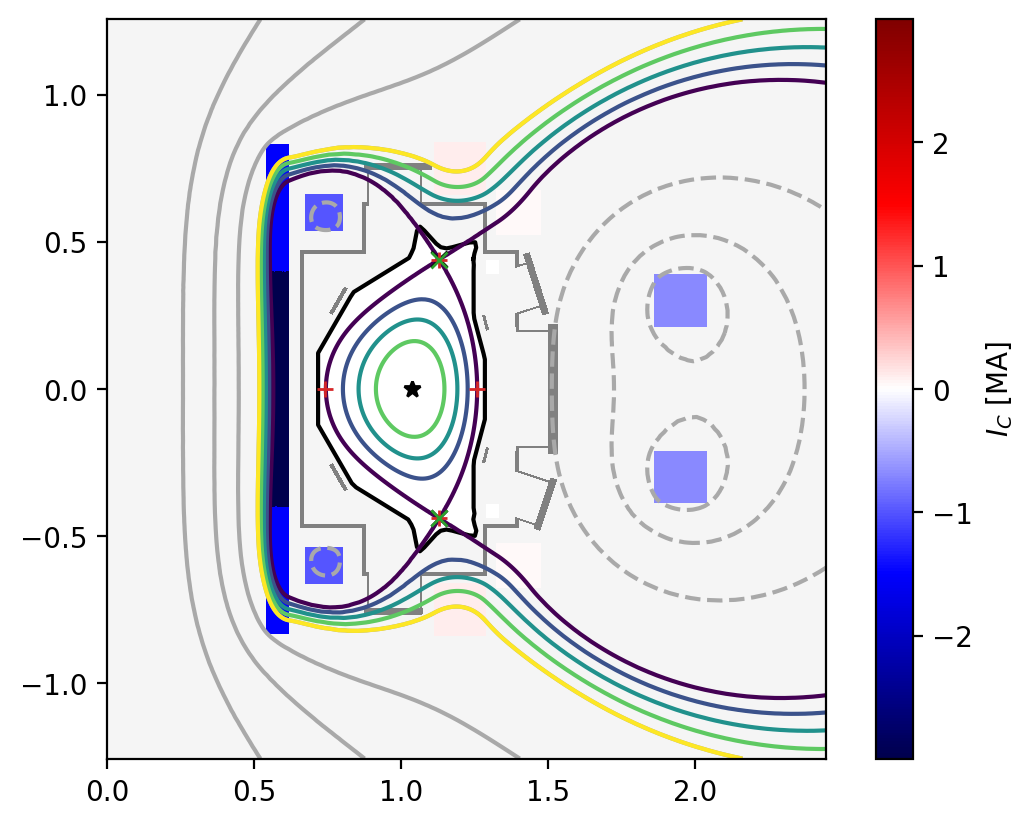

In [15]:

coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Constrain CS current
coil_reg_mat[0,1] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[1,0] = -2
coil_reg_mat[2,2] = -2
coil_reg_mat[2,1] = 1

targets[0] = -3E6

coil_weights[:3] = 5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11

#Set upper bounds on divertor coils
#coil_bounds[-3:-1, 0] = -122448.979592
#coil_bounds[-3:-1, 1] = 122448.979592
coil_bounds[-3:-1, 0] = 0
coil_bounds[-3:-1, 1] = 0

mygs.set_coil_bounds(coil_bounds)

# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 1.25
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 1.25
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

# set global targets
Ip_target = 0.75E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

boundary = create_isoflux(4,1,0.0,0.2588,1.7,-0.5)

x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 50*np.ones(2)
mygs.set_saddles(x_points, x_weights)

isoflux_weights = 100*np.ones(len(boundary))
mygs.set_isoflux(boundary, isoflux_weights)

mygs.init_psi(0.68,0,0.2, 1.8,0.3)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

#plot equilibrium
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,vacuum_nlevels=4,plasma_nlevels=5)
mygs.plot_constraints(fig,ax)

## Compute new forces on TF coils

In [16]:
field_eval = mygs.get_field_eval('B')
B_TF = np.zeros((tf_pts.shape[0],3))
for i in range(tf_pts.shape[0]):
    B_TF[i,:] = field_eval.eval(tf_pts[i,:])
#
inner_R0 = 0.230
leg_width = 0.270
bore = 1.050
height = 2.340
inner_radius = 0.100
leg_thickness = 0.190
TF_current = 313.0*3.E3
#
J_TF = np.zeros((tf_pts.shape[0],2))
for i in range(tf_pts.shape[0]):
    if (abs(tf_pts[i,1]) > (height/2.0 - leg_width - inner_radius)) and abs(tf_pts[i,0]-(inner_R0+leg_width+bore/2.0)) > (bore/2.0-inner_radius):
        if tf_pts[i,0] > 1.0:
            R0 = inner_R0+leg_width+bore-inner_radius
        else:
            R0 = inner_R0+leg_width+inner_radius
        Z0 = np.sign(tf_pts[i,1])*(height/2.0-leg_width-inner_radius)
        theta = np.arctan2(tf_pts[i,1]-Z0,tf_pts[i,0]-R0)
        J_TF[i,:] = [-np.sin(theta),np.cos(theta)]
    elif abs(tf_pts[i,1]) >= height/2.0 - leg_width:
        J_TF[i,:] = [-np.sign(tf_pts[i,1]),0.0]
    else:
        J_TF[i,:] = [0.0,np.sign(tf_pts[i,0]-(inner_R0+leg_width+bore/2.0))]
J_TF *= TF_current/leg_width/leg_thickness

In [17]:
overturning_force = 0.0
overturning_moment = 0.0
for i in range(tf_lc.shape[0]):
    v1 = tf_pts[tf_lc[i,1],:]-tf_pts[tf_lc[i,0],:]
    v2 = tf_pts[tf_lc[i,2],:]-tf_pts[tf_lc[i,0],:]
    area = np.linalg.norm(np.cross(v1,v2))/2.0
    rcc = (tf_pts[tf_lc[i,2],:]+tf_pts[tf_lc[i,1],:]+tf_pts[tf_lc[i,0],:])/3.0
    Jcc = (J_TF[tf_lc[i,2],0]+J_TF[tf_lc[i,1],0]+J_TF[tf_lc[i,0],0])/3.0
    Bcc = (B_TF[tf_lc[i,2],2]+B_TF[tf_lc[i,1],2]+B_TF[tf_lc[i,0],2])/3.0
    overturning_force += np.sign(rcc[1])*area*Jcc*Bcc*leg_thickness
    overturning_moment += rcc[1]*area*Jcc*Bcc*leg_thickness
print('Overturning force per half coil = {0:10.2F} [kN]'.format(overturning_force/2.0/1.E3))
print('Overturning moment per coil     = {0:10.2F} [kN-m]'.format(overturning_moment/1.E3))

Overturning force per half coil =     813.25 [kN]
Overturning moment per coil     =    1655.92 [kN-m]


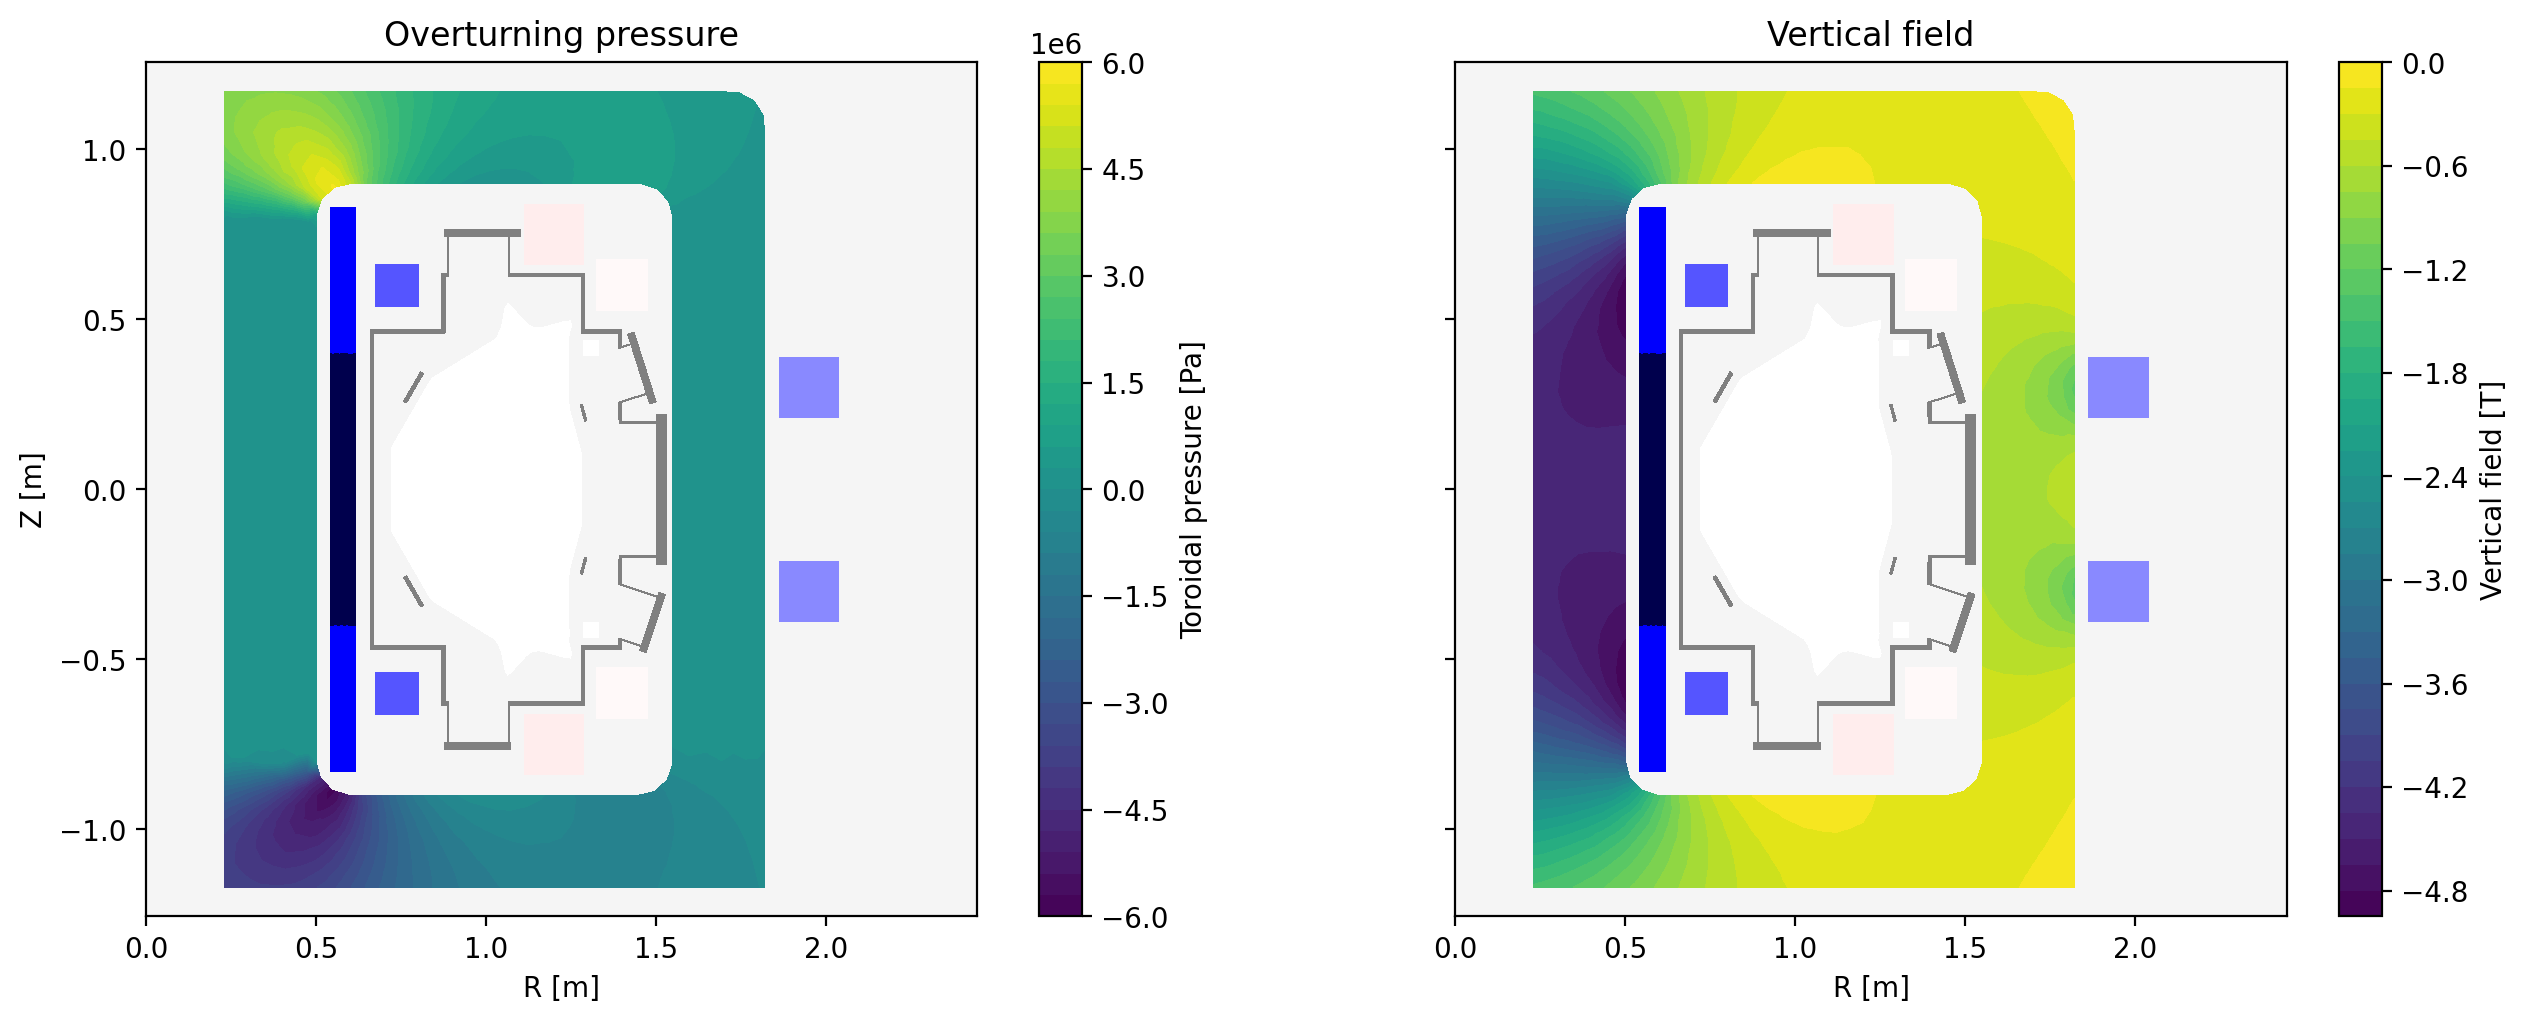

In [18]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(13,5),constrained_layout=True)
mygs.plot_machine(fig,ax[1],limiter_color=None,coil_colormap='seismic',coil_symmap=True,coil_clabel=None)
clf = ax[1].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,B_TF[:,2],40)
fig.colorbar(clf,ax=ax[1],label='Vertical field [T]')
_ = ax[1].set_title('Vertical field')

mygs.plot_machine(fig,ax[0],limiter_color=None,coil_colormap='seismic',coil_symmap=True,coil_clabel=None)
clf = ax[0].tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,J_TF[:,0]*B_TF[:,2]*leg_thickness,40)
fig.colorbar(clf,ax=ax[0],label='Toroidal pressure [Pa]')
_ = ax[0].set_title('Overturning pressure')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
_ = ax[1].set_xlabel('R [m]')

Text(0, 0.5, 'Z (m)')

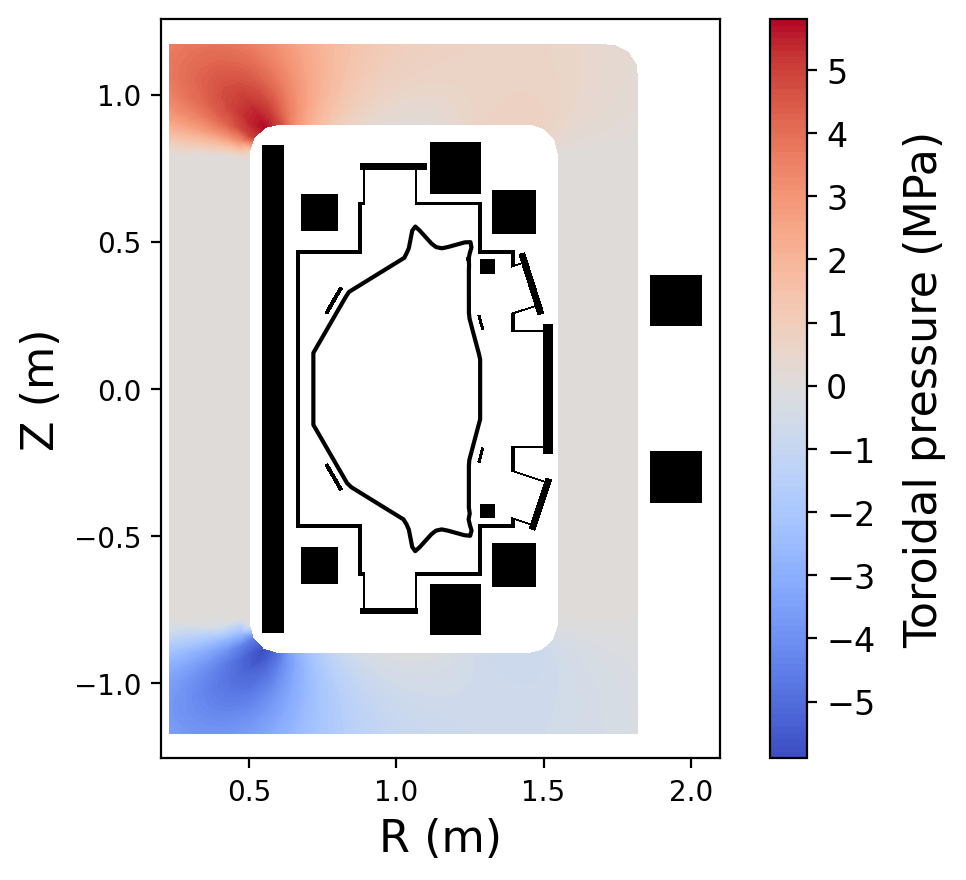

In [19]:
fig, ax = plt.subplots()
plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
mygs.plot_machine(fig,ax, vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
plt.rcParams['lines.linewidth']=1
#mygs.plot_psi(fig, ax, plasma_nlevels = 4, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
#mygs.plot_constraints(fig, ax[i])
plt.rcParams['lines.linewidth']=2.0
#mygs.plot_psi(fig, ax, plasma_nlevels = 1, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
clf = ax.tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,(J_TF[:,0]*B_TF[:,2]*leg_thickness)/1E6,120, cmap = 'coolwarm', zorder = 10)
cb = fig.colorbar(clf,ax=ax,label='Toroidal pressure (MPa)', ticks = [-5,-4, -3, -2, -1,0,1,2,3,4,5])
cb.set_label(label='Toroidal pressure (MPa)', fontsize = 16, labelpad = 10)
plt.xlim([0.2,2.1])
plt.xlabel('R (m)', fontsize = 16)
plt.ylabel('Z (m)', fontsize = 16)


## Compute new forces on PF coils

Text(1.89, -0.83, '(b)')

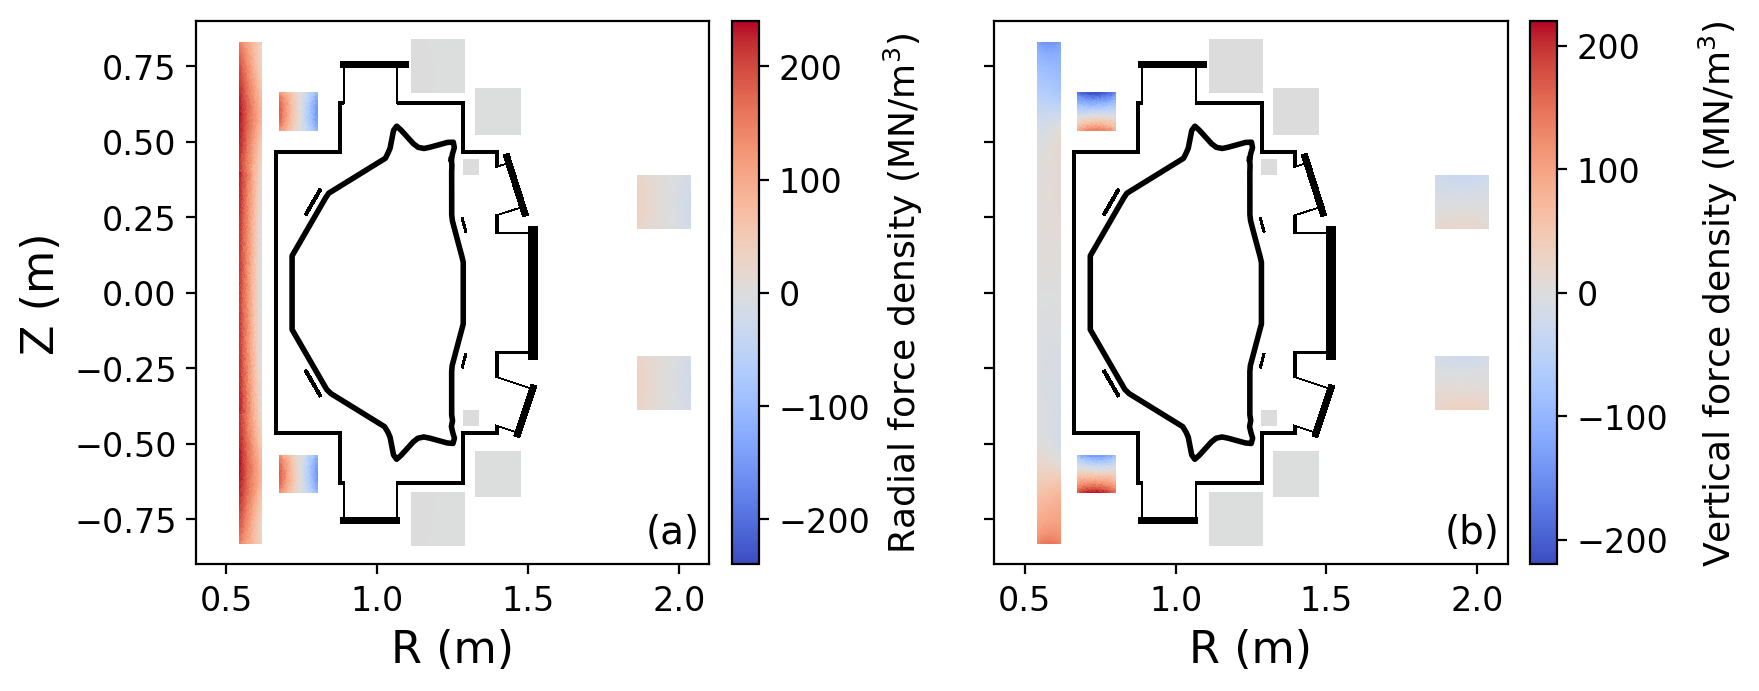

In [20]:
coil_currents, reg_currents = mygs.get_coil_currents()
B_PF = np.zeros((mesh_pts.shape[0],3))
F_PF = np.zeros((mesh_lc.shape[0],2))
F_PF[:] = np.NaN
pt_mask = np.zeros((mesh_pts.shape[0],), dtype=np.int32)
for key, coil in coil_dict.items():
    pt_mask[mesh_lc[mesh_reg==coil['reg_id'],:]] = 1
for i in range(mesh_pts.shape[0]):
    if pt_mask[i] == 0:
        continue
    B_PF[i,:] = field_eval.eval(mesh_pts[i,:])
for key, coil in mygs.coil_sets.items():
    coil_area = 0.0
    coil_force = np.array([0.0,0.0])
    for subcoil in coil['sub_coils']:
        subcoil_area = 0.0
        nc = np.sum(mesh_reg==subcoil['reg_id'])
        Bcc = np.zeros((nc,3))
        for i, lc in enumerate(mesh_lc[mesh_reg==subcoil['reg_id'],:]):
            v1 = mesh_pts[lc[1],:]-mesh_pts[lc[0],:]
            v2 = mesh_pts[lc[2],:]-mesh_pts[lc[0],:]
            area = np.linalg.norm(np.cross(v1,v2))/2.0
            rcc = (mesh_pts[lc[2],:]+mesh_pts[lc[1],:]+mesh_pts[lc[0],:])/3.0
            Bcc[i,:] = (B_PF[lc[2],:]+B_PF[lc[1],:]+B_PF[lc[0],:])/3.0
            coil_force += Bcc[i,[2,0]]*reg_currents[subcoil['reg_id']-1]*area*2.0*np.pi*rcc[0]
            subcoil_area += area
        coil_area += subcoil_area
        Jtor_subcoil = coil_currents[coil['id']]*subcoil['nturns']/subcoil_area
        F_PF[mesh_reg==subcoil['reg_id'],0] = Bcc[:,2]*Jtor_subcoil
        F_PF[mesh_reg==subcoil['reg_id'],1] = -Bcc[:,0]*Jtor_subcoil
    coil_force /= coil_area
    #print('{0:4} {1:14.4E} {2:14.4E}'.format(key,coil_force[0],-coil_force[1]))

# Plot results
fig, ax = plt.subplots(1,2,figsize=(8.6,5*2/3),sharey=True,constrained_layout=True)
mygs.plot_machine(fig,ax[0], vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
plt.rcParams['lines.linewidth']=1
#mygs.plot_psi(fig, ax[0], plasma_nlevels = 4, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
#mygs.plot_constraints(fig, ax[i])
plt.rcParams['lines.linewidth']=2.0
#mygs.plot_psi(fig, ax[0], plasma_nlevels = 1, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
mygs.plot_machine(fig,ax[1], vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
plt.rcParams['lines.linewidth']=1
#mygs.plot_psi(fig, ax[1], plasma_nlevels = 4, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
#mygs.plot_constraints(fig, ax[i])
plt.rcParams['lines.linewidth']=2.0
#mygs.plot_psi(fig, ax[1], plasma_nlevels = 1, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
# Radial force
rad = ax[0].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,0]/1.E6, cmap = 'coolwarm', vmin = -240, vmax = 240, zorder = 10)
cb = fig.colorbar(rad,ax=ax[0],fraction=0.053, pad=0.04)
cb.set_label(label=r'Radial force density ($\mathrm{MN}/\mathrm{m}^3$)', fontsize = 13)
ax[0].set_ylabel('Z (m)', fontsize = 16)
ax[0].set_xlabel('R (m)', fontsize = 16)
# Vertical force
ver = ax[1].tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,1]/1.E6, cmap = 'coolwarm', vmin = -220, vmax = 220, zorder = 10)
cb = fig.colorbar(ver,ax=ax[1],fraction=0.053, pad=0.04)
cb.set_label(label=r'Vertical force density ($\mathrm{MN}/\mathrm{m}^3$)', fontsize = 13, labelpad = 10)
_ = ax[1].set_xlabel('R (m)', fontsize = 16)

for a in ax:
    a.set_xlim([0.4, 2.1])
    a.set_ylim([-0.9, 0.9])

ax[0].text(1.89, -0.83,'(a)', fontsize = 14)
ax[1].text(1.89, -0.83,'(b)', fontsize = 14)


(-0.9, 0.9)

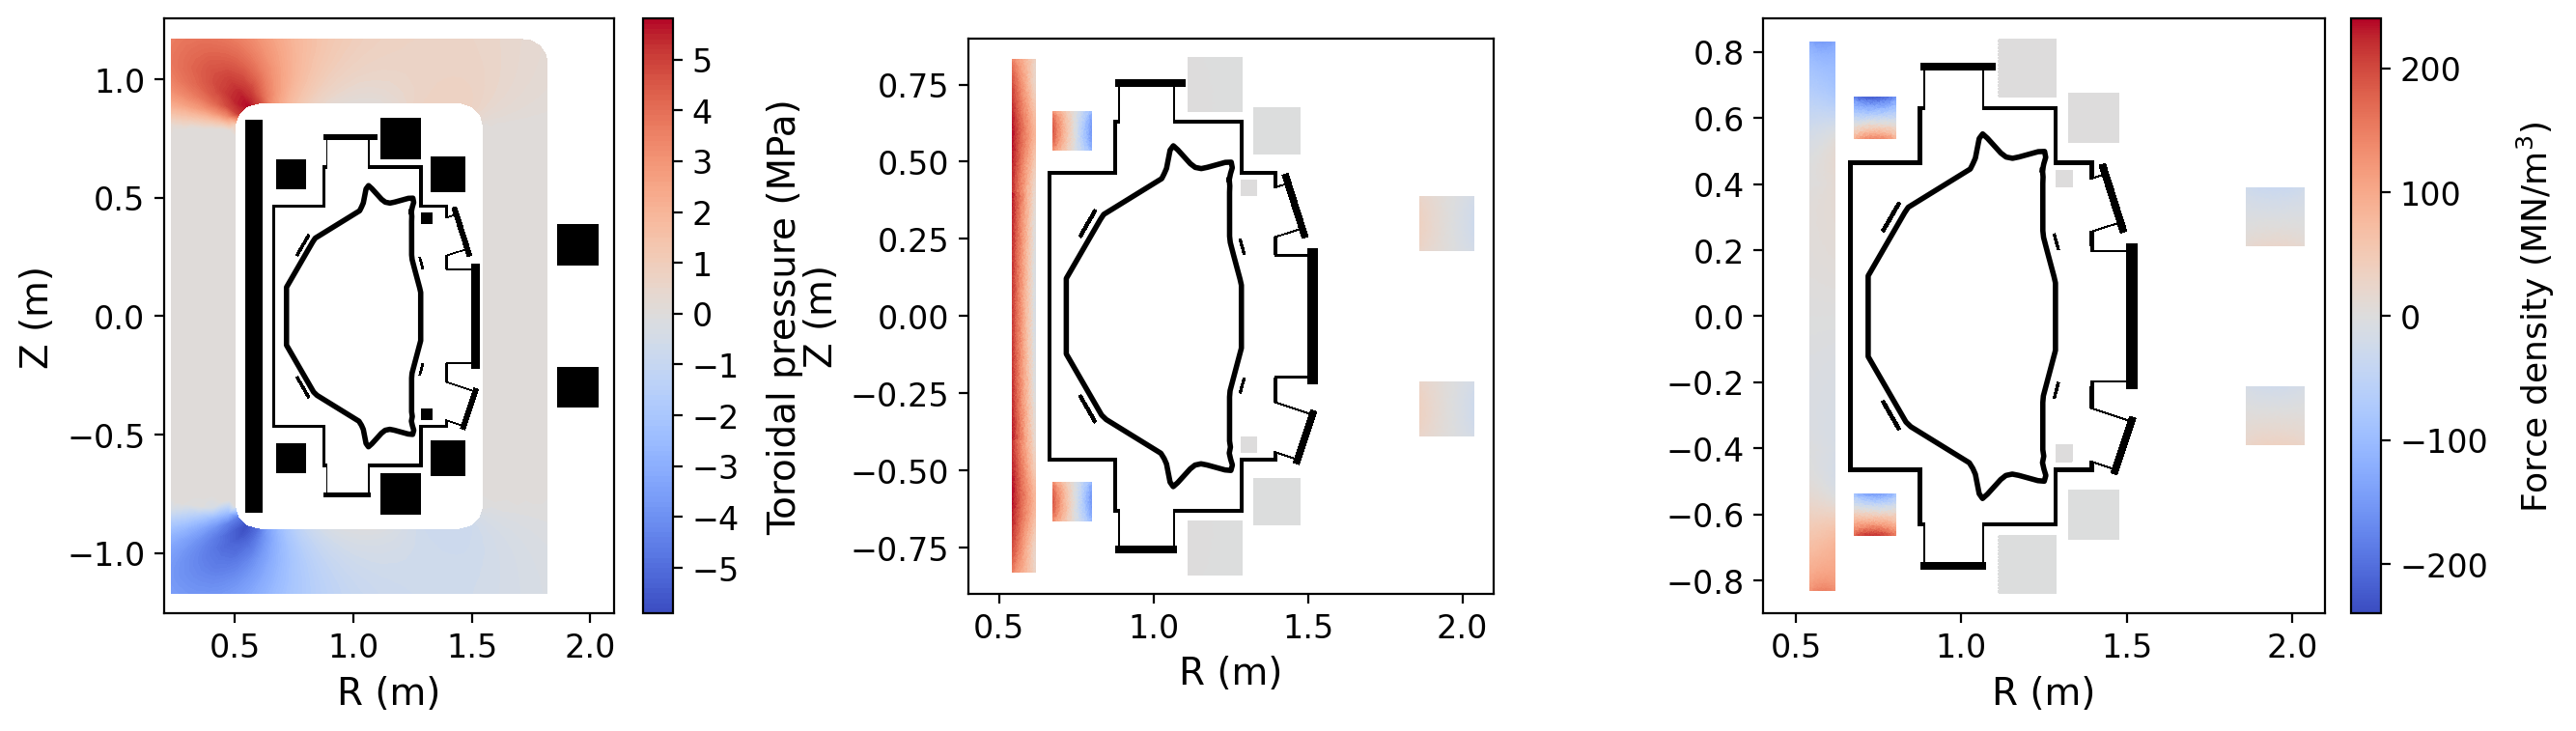

In [21]:
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 3, width_ratios=[0.9, 0.8,1], wspace = 0.4)

fig = plt.figure(figsize=(15,4 ))

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])

mygs.plot_machine(fig,ax0, vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
plt.rcParams['lines.linewidth']=1
#mygs.plot_psi(fig, ax, plasma_nlevels = 4, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
#mygs.plot_constraints(fig, ax[i])
plt.rcParams['lines.linewidth']=2.0
#mygs.plot_psi(fig, ax, plasma_nlevels = 1, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
clf = ax0.tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,(J_TF[:,0]*B_TF[:,2]*leg_thickness)/1E6,120, cmap = 'coolwarm', zorder = 10)
cb = fig.colorbar(clf,ax=ax0,label='Toroidal pressure (MPa)', ticks = [-5,-4, -3, -2, -1,0,1,2,3,4,5])
cb.set_label(label='Toroidal pressure (MPa)', fontsize = 14, labelpad = 10)
ax0.set_xlim([0.2,2.1])
ax0.set_xlabel('R (m)', fontsize = 14)
ax0.set_ylabel('Z (m)', fontsize = 14)


mygs.plot_machine(fig,ax1, vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
plt.rcParams['lines.linewidth']=1
#mygs.plot_psi(fig, ax[0], plasma_nlevels = 4, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
#mygs.plot_constraints(fig, ax[i])
plt.rcParams['lines.linewidth']=2.0
#mygs.plot_psi(fig, ax[0], plasma_nlevels = 1, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
mygs.plot_machine(fig,ax2, vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
plt.rcParams['lines.linewidth']=1
#mygs.plot_psi(fig, ax[1], plasma_nlevels = 4, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
#mygs.plot_constraints(fig, ax[i])
plt.rcParams['lines.linewidth']=2.0
#mygs.plot_psi(fig, ax[1], plasma_nlevels = 1, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
# Radial force
rad = ax1.tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,0]/1.E6, cmap = 'coolwarm', vmin = -240, vmax = 240, zorder = 10)
ax1.set_ylabel('Z (m)', fontsize = 14)
ax1.set_xlabel('R (m)', fontsize = 14)
# Vertical force
ver = ax2.tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,1]/1.E6, cmap = 'coolwarm', vmin = -240, vmax = 240, zorder = 10)
cb = fig.colorbar(ver,ax=ax2,fraction=0.053, pad=0.04)
cb.set_label(label=r'Force density ($\mathrm{MN}/\mathrm{m}^3$)', fontsize = 13, labelpad = 10)
_ = ax2.set_xlabel('R (m)', fontsize = 14)

ax1.set_xlim([0.4, 2.1])
ax2.set_xlim([0.4, 2.1])
ax1.set_ylim([-0.9, 0.9])
ax2.set_ylim([-0.9, 0.9])






Text(1.91, -0.84, '(c)')

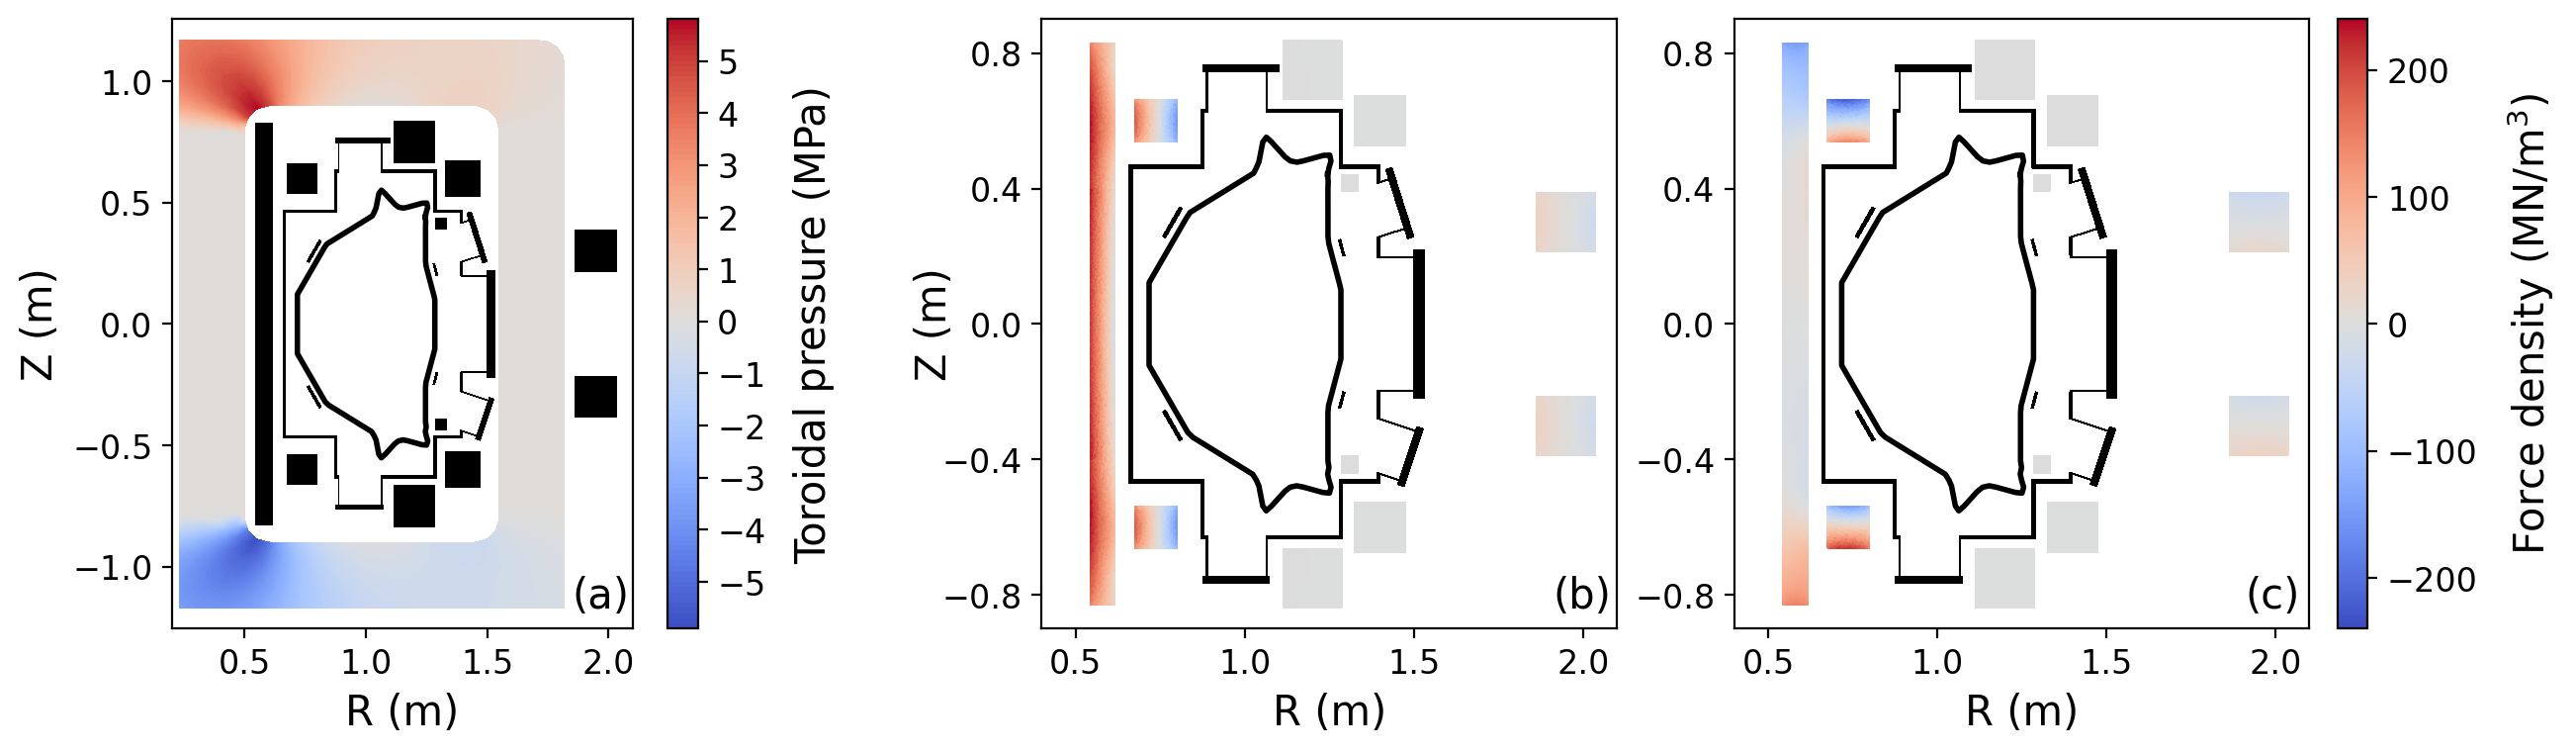

In [22]:
import matplotlib.gridspec as gridspec
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
fig = plt.figure(figsize = (15,4))

gs0 = gridspec.GridSpec(1, 2, figure=fig, width_ratios = [1,2])

gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1], wspace = 0)

ax0 = fig.add_subplot(gs0[0])
ax1 = fig.add_subplot(gs00[0])
ax2 = fig.add_subplot(gs00[1])

mygs.plot_machine(fig,ax0, vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
clf = ax0.tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,(J_TF[:,0]*B_TF[:,2]*leg_thickness)/1E6,120, cmap = 'coolwarm', zorder = 10)
cb = fig.colorbar(clf,ax=ax0,label='Toroidal pressure (MPa)', ticks = [-5,-4, -3, -2, -1,0,1,2,3,4,5])
cb.set_label(label='Toroidal pressure (MPa)', fontsize = 15, labelpad = 10)
ax0.set_xlim([0.2,2.1])
ax0.set_xlabel('R (m)', fontsize = 15)
ax0.set_ylabel('Z (m)', fontsize = 15)

mygs.plot_machine(fig,ax1, vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
mygs.plot_machine(fig,ax2, vacuum_color = 'w', coil_color = 'k', cond_color = 'k')

rad = ax1.tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,0]/1.E6, cmap = 'coolwarm', vmin = -240, vmax = 240, zorder = 10)
ax1.set_ylabel('Z (m)', fontsize = 15, labelpad = -5)
ax1.set_xlabel('R (m)', fontsize = 15)

ver = ax2.tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,1]/1.E6, cmap = 'coolwarm', vmin = -240, vmax = 240, zorder = 10)
cb = fig.colorbar(ver,ax=ax2,fraction=0.053, pad=0.04)
cb.set_label(label=r'Force density ($\mathrm{MN}/\mathrm{m}^3$)', fontsize = 15, labelpad = 10)
_ = ax2.set_xlabel('R (m)', fontsize = 15)

ax1.set_xlim([0.4, 2.1])
ax2.set_xlim([0.4, 2.1])
ax1.set_ylim([-0.9, 0.9])
ax2.set_ylim([-0.9, 0.9])

ax1.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
ax2.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])

ax0.text(1.85, -1.17, '(a)', fontsize = 15)
ax1.text(1.91, -0.84, '(b)', fontsize = 15)
ax2.text(1.91, -0.84, '(c)', fontsize = 15)

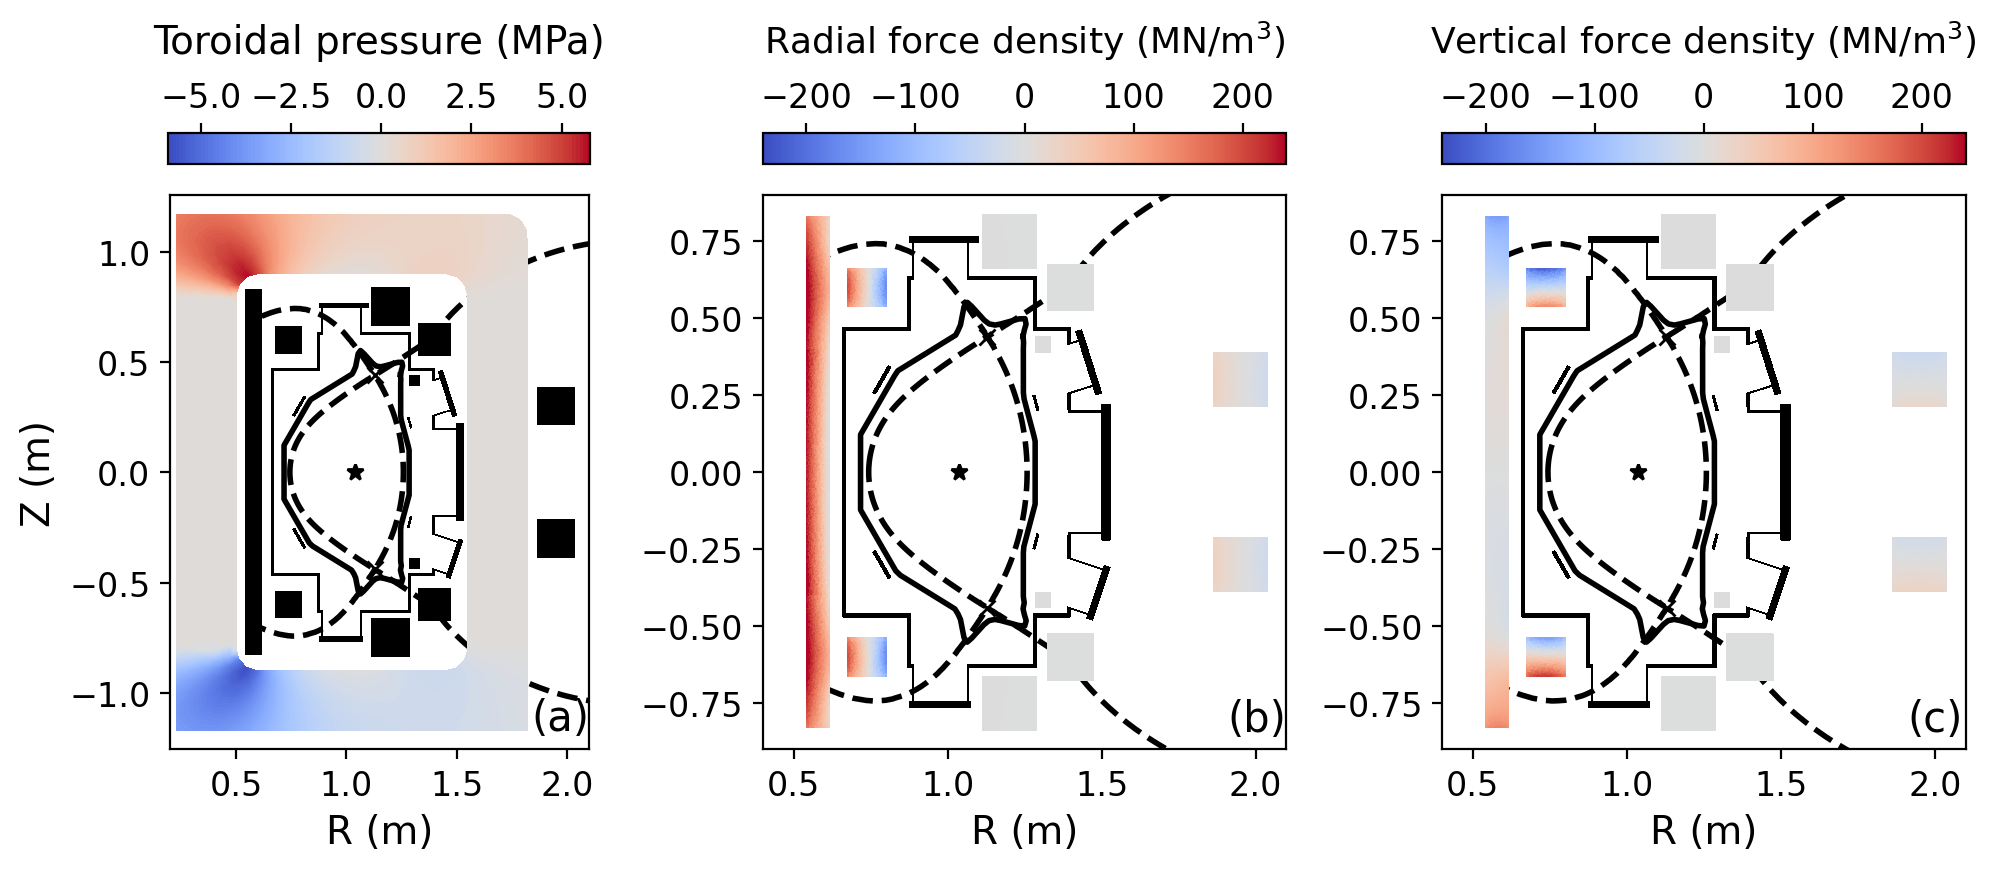

In [32]:
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 3, width_ratios=[0.88, 1,1])

fig = plt.figure(figsize=(12,4 ))

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])

mygs.plot_machine(fig,ax0, vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
plt.rcParams['lines.linewidth']=1
#mygs.plot_psi(fig, ax, plasma_nlevels = 4, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
#mygs.plot_constraints(fig, ax[i])
plt.rcParams['lines.linewidth']=2.0
#mygs.plot_psi(fig, ax, plasma_nlevels = 1, vacuum_nlevels = 0, xpoint_color = None, xpoint_marker = None, plasma_color = 'k')
clf = ax0.tricontourf(tf_pts[:,0],tf_pts[:,1],tf_lc,(J_TF[:,0]*B_TF[:,2]*leg_thickness)/1E6,120, cmap = 'coolwarm', zorder = 10)
cb = fig.colorbar(clf,ax=ax0,location = 'top', fraction = 0.05, aspect = 13.7, ticks = [-5, -2.5, 0, 2.5, 5])
#cb.ax.tick_params(labelsize=9)
cb.set_label(label='Toroidal pressure (MPa)', fontsize = 14, labelpad = 10)
ax0.set_xlim([0.2,2.1])
ax0.set_xlabel('R (m)', fontsize = 14)
ax0.set_ylabel('Z (m)', fontsize = 14)

mygs.plot_machine(fig,ax1, vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
mygs.plot_machine(fig,ax2, vacuum_color = 'w', coil_color = 'k', cond_color = 'k')
# Radial force
rad = ax1.tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,0]/1.E6, cmap = 'coolwarm', vmin = -220, vmax = 220, zorder = 10)
cb = fig.colorbar(ver,ax=ax1, location = 'top', fraction = 0.05, aspect = 17)
cb.set_label(label=r'Radial force density ($\mathrm{MN}/\mathrm{m}^3$)', fontsize = 13, labelpad = 10)
ax1.set_xlabel('R (m)', fontsize = 14)
# Vertical force
ver = ax2.tripcolor(mesh_pts[:,0],mesh_pts[:,1],mesh_lc,F_PF[:,1]/1.E6, cmap = 'coolwarm', vmin = -240, vmax = 240, zorder = 10)
cb = fig.colorbar(ver,ax=ax2, location = 'top', fraction = 0.05, aspect = 17)
cb.set_label(label=r'Vertical force density ($\mathrm{MN}/\mathrm{m}^3$)', fontsize = 13, labelpad = 10)
_ = ax2.set_xlabel('R (m)', fontsize = 14)

ax1.set_xlim([0.4, 2.1])
ax2.set_xlim([0.4, 2.1])
ax1.set_ylim([-0.9, 0.9])
ax2.set_ylim([-0.9, 0.9])

ax0.text(1.84, -1.17, '(a)', fontsize = 15)
ax1.text(1.91, -0.84, '(b)', fontsize = 15)
ax2.text(1.91, -0.84, '(c)', fontsize = 15)

mygs.plot_psi(fig,ax0, plasma_nlevels = 1, plasma_linestyles='--', vacuum_nlevels = 0, plasma_color = 'k')
mygs.plot_psi(fig,ax1, plasma_nlevels = 1, plasma_linestyles='--', vacuum_nlevels = 0, plasma_color = 'k')
mygs.plot_psi(fig,ax2, plasma_nlevels = 1, plasma_linestyles='--', vacuum_nlevels = 0, plasma_color = 'k')